**CIFAR-10 Image Classification using ResNet50 **

This notebook implements a transfer learning approach using a pretrained
ResNet50 model to classify images from the CIFAR-10 dataset.

> Note: This project was developed as part of a Deep Learning course assignment.



# ***Import Libraries***

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt



# ***Set Seed and Hyperparameters***

In [ ]:
batch_size = 64
learning_rate = 1e-4
num_epochs = 15
img_size = 128
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# ***Dataset Preparation***



The CIFAR-10 dataset is used for image classification.
Data augmentation is applied to the training set only.


In [ ]:
data_dir = "dataset/cifar10-competition"

# Read CSVs
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_df  = pd.read_csv(os.path.join(data_dir, "test.csv"))

# Split train/validation
from sklearn.model_selection import train_test_split
train_split, val_split = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=seed
)

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [ ]:
class CIFARDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image name as string and pad with zeros to 5 digits
        img_id = str(self.df.iloc[idx, 0]).zfill(5)
        img_name = f"{img_id}.png"
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = int(self.df.iloc[idx, 1])
            return image, label
        else:
            return image

# Datasets
train_dataset = CIFARDataset(train_split, os.path.join(data_dir, "train"), train_transforms, train=True)
val_dataset   = CIFARDataset(val_split,   os.path.join(data_dir, "train"), test_transforms, train=True)
test_dataset  = CIFARDataset(test_df,     os.path.join(data_dir, "test"),  test_transforms, train=False)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)},  Val: {len(val_dataset)},  Test: {len(test_dataset)}")

Train: 40000,  Val: 10000,  Test: 10000


# ***Model Definition (ResNet50)***



A pretrained ResNet50 model is adapted for CIFAR-10 classification
by replacing the final fully connected layer.


In [ ]:
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50Classifier, self).__init__()
        self.model = resnet50(weights="DEFAULT")
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet50Classifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


# ***Training & Validation Loop***


The model is trained using cross-entropy loss and Adam optimizer,
with learning rate scheduling and early stopping.

In [ ]:
num_epochs = 15
patience = 5  # number of epochs to wait before stopping if no improvement

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0.0
best_epoch = 0
no_improve_epochs = 0  # counter for early stopping

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 40)

    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    scheduler.step()

    # Save best model
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Early Stopping trigger
    if no_improve_epochs >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}.")
        break

print(f"\nBest Epoch: {best_epoch} | Best Val Accuracy: {best_acc:.4f}")



Epoch 1/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.39it/s]


Train Acc: 0.8889 | Val Acc: 0.9574

Epoch 2/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.41it/s]


Train Acc: 0.9581 | Val Acc: 0.9622

Epoch 3/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.15it/s]


Train Acc: 0.9721 | Val Acc: 0.9655

Epoch 4/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.56it/s]


Train Acc: 0.9810 | Val Acc: 0.9663

Epoch 5/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.27it/s]


Train Acc: 0.9843 | Val Acc: 0.9658

Epoch 6/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.29it/s]


Train Acc: 0.9898 | Val Acc: 0.9675

Epoch 7/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.50it/s]


Train Acc: 0.9909 | Val Acc: 0.9711

Epoch 8/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s]


Train Acc: 0.9937 | Val Acc: 0.9695

Epoch 9/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.33it/s]


Train Acc: 0.9949 | Val Acc: 0.9738

Epoch 10/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:12<00:00, 13.08it/s]


Train Acc: 0.9969 | Val Acc: 0.9740

Epoch 11/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.26it/s]


Train Acc: 0.9979 | Val Acc: 0.9744

Epoch 12/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.18it/s]


Train Acc: 0.9984 | Val Acc: 0.9750

Epoch 13/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:12<00:00, 12.77it/s]


Train Acc: 0.9987 | Val Acc: 0.9773

Epoch 14/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.09it/s]


Train Acc: 0.9992 | Val Acc: 0.9762

Epoch 15/15
----------------------------------------


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.22it/s]

Train Acc: 0.9994 | Val Acc: 0.9764

Best Epoch: 13 | Best Val Accuracy: 0.9773


## ***Evaluation***

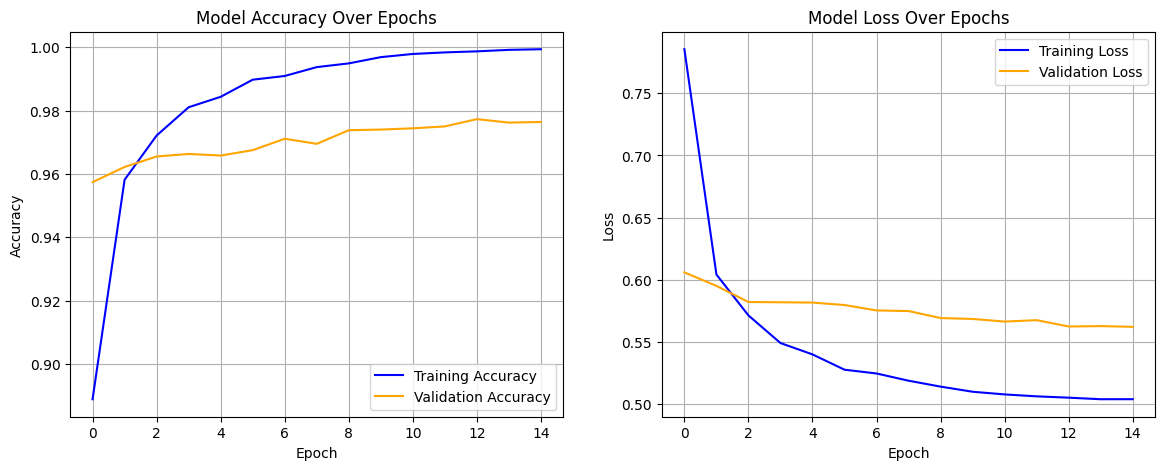

Final Validation Accuracy: 97.64%
Final Validation Loss: 0.5622


In [ ]:

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")


# ***Prediction + Submission***

In [ ]:
from tqdm import tqdm
import pandas as pd

model.eval()
predictions = []

with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Generating Predictions (Current Model)"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        predictions.extend(preds)

# Load test CSV to get IDs
test_csv = pd.read_csv("dataset/cifar10-competition/test.csv")

submission = pd.DataFrame({
    'id': test_csv['id'],
    'label': predictions
})

submission.to_csv("submission_current_model.csv", index=False)

print("Submission file 'submission_current_model.csv' created successfully.")
print(submission.head())



Generating Predictions (Current Model): 100%|██████████| 157/157 [00:11<00:00, 13.55it/s]

Submission file 'submission_current_model.csv' created successfully.
      id  label
0  50001      2
1  50002      5
2  50003      4
3  50004      4
4  50005      6


# ***References***


[1] A. Krizhevsky, “Learning Multiple Layers of Features from Tiny Images,” University of Toronto, 2009.  
https://www.cs.toronto.edu/~kriz/cifar.html

[2] K. He et al., “Deep Residual Learning for Image Recognition,” CVPR 2016.  
https://arxiv.org/abs/1512.03385

[3] J. Yosinski et al., “How Transferable Are Features in Deep Neural Networks,” NeurIPS 2014.  
https://arxiv.org/abs/1411.1792

[4] PyTorch Documentation.  
https://pytorch.org/docs/stable/index.html

[5] Torchvision Models Documentation.  
https://pytorch.org/vision/stable/models.html
